## Imports

Libraries and device

In [ ]:
# Standard imports
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

!pip install snntorch
import snntorch as snn
import snntorch.spikegen as spikegen
from snntorch import surrogate
from snntorch import utils
# from snntorch import spikegen

# In case you are fortunate enough to have access to a GPU...
device = 'cuda' if torch.cuda.is_available() else 'cpu'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 5.2 MB/s eta 0:00:00


## Data

Import Data: Flattened MNIST

In [ ]:
img_size = 28
ds = torchvision.datasets.MNIST('./files/', train=True, download=True,
                            transform=T.Compose([
                                T.Resize((img_size,img_size)),
                                T.ToTensor(),
                                T.Lambda((lambda x: torch.flatten(x))),
                            ]))

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


Import Data: Flattened CIFAR-10

In [ ]:
# img_size = 28

# ds = torchvision.datasets.CIFAR10(
#     './files/', train=False, download=True,
#     transform=T.Compose([
#         T.Resize((img_size, img_size)),     # Resize to 28x28
#         T.ToTensor(),                       # Convert to tensor
#         T.Lambda(lambda x: x.view(-1)),     # Flatten the image
#     ])
# )


Load pretrained MNIST Classifier

In [ ]:
class MyNet(nn.Module):
    '''
     net = MyNet(img_size=28)

     Creates a neural network to do classification on MNIST.
     It assumes the images will be (img_size)x(img_size).

     The output of the network is the log of the 10 class probabilities
     (ie. log-softmax). Correspondingly, this network uses the
     negative log-likelihood loss function (nn.NLLLoss).
    '''
    def __init__(self, img_size=28):
        super().__init__()
        self.lyrs = nn.Sequential(
            nn.Linear(img_size**2, 100), nn.ReLU(),
            nn.Linear(100, 50), nn.ReLU(),
            nn.Linear(50, 10), nn.LogSoftmax(dim=-1),
            )
        self.loss_fcn = nn.NLLLoss()
        self.losses = []
        self.to(device)


    def forward(self, x):
        return self.lyrs(x)


    def learn(self, dl, optimizer=None, epochs=10):
        '''
         net.learn(dl, optimizer=None, epochs=10)

         Train the network on the dataset represented by the DataLoader dl.
         The default optimizer is Adam().

         The targets for the dataset are assumed to be class indices.
        '''
        if optimizer is None:
            print('Need to specify an optimizer and loss function')
            return

        for epoch in tqdm(range(epochs)):
            total_loss = 0.
            count = 0.
            for x, t in dl:
                x = x.to(device)   # for use with a GPU
                t = t.to(device)
                y = self(x)
                loss = self.loss_fcn(y, t)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.detach().numpy()
                count += 1.
            self.losses.append(total_loss/len(dl))
            #print(f'Epoch: {epoch}, loss: {total_loss/count}')
        plt.figure(figsize=(4,4))
        plt.plot(self.losses); plt.yscale('log');

net = torch.load('mnist_trained2.pt', weights_only=False).to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'mnist_trained2.pt'

Functions for adding noise to the MNIST data (noisier data will have a high classification difficulty score, which will be useful for curriculum learning training)

In [ ]:
def add_noise_binary_flip(images, noise_level=0.2):
    noisy_images = images.clone()
    noise = torch.rand_like(noisy_images)
    flip_mask = noise < noise_level
    noisy_images[flip_mask] = 1 - noisy_images[flip_mask]
    return noisy_images

def add_noise_gaussian(images, std=0.2):
    noisy_images = images + torch.randn_like(images) * std
    noisy_images = torch.clamp(noisy_images, 0.0, 1.0)
    return noisy_images

def add_noise_salt_pepper(images, noise_level=0.2):
    noisy_images = images.clone()
    rand = torch.rand_like(noisy_images)
    noisy_images[rand < (noise_level / 2)] = 0.0    # Pepper
    noisy_images[(rand >= (noise_level / 2)) & (rand < noise_level)] = 1.0  # Salt
    return noisy_images

def add_noise_block(images, block_size=7, img_size=28):
    images = images.view(-1, 1, img_size, img_size).clone() # Unflatten images: [B, 784] → [B, 1, 28, 28]

    for img in images:
        x = torch.randint(0, img_size - block_size + 1, (1,))
        y = torch.randint(0, img_size - block_size + 1, (1,))
        img[:, y:y+block_size, x:x+block_size] = 0.0

    return images.view(-1, img_size * img_size) # Flatten back: [B, 1, 28, 28] → [B, 784]

Create datasets for curriculum learning

In [ ]:
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4]

def create_noisy_datasets(func):
    def accuracy(net, dl):
        total_correct = 0.
        for x,t in dl:
            y = net(x.to(device))
            blah = torch.argmax(y.cpu(), dim=1)
            total_correct += torch.sum(blah==t).cpu().item()
        return total_correct/len(dl.dataset)

    dl = torch.utils.data.DataLoader(ds, batch_size=256)


    # block_sizes = [1, 3, 5, 7, 9]
    datasets = {}

    for noise_level in noise_levels:
        print(f'Noise level: {noise_level}')
        # Collect all images and labels with noise
        all_noisy_images = []
        all_labels = []


        for batch in dl:
            images, labels = batch
            noisy_images = func(images, noise_level)
            all_noisy_images.append(noisy_images)
            all_labels.append(labels)

        # Combine into one dataset
        all_noisy_images = torch.cat(all_noisy_images, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        # Create new dataloader with noisy images
        noisy_ds = torch.utils.data.TensorDataset(all_noisy_images, all_labels)
        noisy_dl = torch.utils.data.DataLoader(noisy_ds, batch_size=256, shuffle=False)

        datasets[noise_level] = noisy_ds

        # acc = accuracy(net, noisy_dl)
        # print(f'Accuracy = {acc*100.:0.2f}%')

    return datasets

print("Binary Flip Noise Dataset")
binary_flip_datasets = create_noisy_datasets(add_noise_binary_flip)
# print("Gaussian Noise Dataset")
# gaussian_datasets = create_noisy_datasets(add_noise_gaussian)
# print("Salt and Pepper Noise Dataset")
# salt_pepper_datasets = create_noisy_datasets(add_noise_salt_pepper)

# change noise levels
# train for more epochs
# plot loss and accuracy graphs
# repeat exp with diff types noise

Binary Flip Noise Dataset
Noise level: 0.0
Noise level: 0.1
Noise level: 0.2
Noise level: 0.3
Noise level: 0.4


We can see that the pre-trained classifier performs worse when more noise is added to the data. In other words, noisier data is harder to classify. So by varying noise levels in MNIST, we've created a progressive difficulty spectrum which will be our curriculum.

In [ ]:
# train_ds, test_ds = torch.utils.data.random_split(binary_flip_datasets[0.4], [0.2,0.8])

# total_len = len(binary_flip_datasets[0.4])
# #for 80%
# # train_len = int(0.2 * total_len)
# # test_len = total_len - train_len

# train_len = test_len = total_len // 2
# train_ds, test_ds = torch.utils.data.random_split(binary_flip_datasets[0.4], [train_len, test_len])


# combined_ds = torch.utils.data.ConcatDataset([binary_flip_datasets[noise_levels[0]], binary_flip_datasets[noise_levels[1]], binary_flip_datasets[noise_levels[2]], binary_flip_datasets[noise_levels[3]], train_ds])
# train_dl = DataLoader(combined_ds, batch_size=256, shuffle=True)
# test_dl = DataLoader(test_ds, batch_size=256)

#--- using some parts of all noise level data---
from torch.utils.data import random_split, ConcatDataset

# Split 0.4 noise data into train/test
# total_len = len(binary_flip_datasets[0.4])
# train_len = test_len = total_len // 2
# train_ds, test_ds_04 = random_split(binary_flip_datasets[0.4], [train_len, test_len])

# Sample 50% from each 0.0–0.3 dataset to use for testing
train_parts = []
test_parts = []
for nl in noise_levels:
    full_ds = binary_flip_datasets[nl]
    test_size = int(0.5 * len(full_ds))
    train_part, test_part = random_split(full_ds, [len(full_ds) - test_size, test_size])
    train_parts.append(train_part)
    test_parts.append(test_part)

# Combine all test subsets
test_ds = ConcatDataset(test_parts)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)

# Combine training data from all levels, shuffle
combined_train_ds = ConcatDataset(train_parts)
combined_train_dl = DataLoader(combined_train_ds, batch_size=256, shuffle=True)

## Train & Eval

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Train function (also tracks accuracy)
def train_model(model, train_dl, test_dl, loss_fn, optimizer, epochs=10, patience=15, save_path="last_model.pth"):
    model.train()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    best_acc = 0.0
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0
        all_preds = []
        all_labels = []

        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)

            pred = model(xb)
            loss = loss_fn(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            all_preds += pred.argmax(dim=1).tolist()
            all_labels += yb.tolist()

        avg_loss = total_loss / len(train_dl)
        acc = accuracy_score(all_labels, all_preds)
        train_losses.append(avg_loss)
        train_accuracies.append(acc)

        # Evaluate on test set
        test_loss, test_acc = evaluate_with_loss(model, test_dl, loss_fn)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {avg_loss:.4f}, Train Acc: {acc:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # Early stopping based on test accuracy
        if test_acc > best_acc:
            best_acc = test_acc
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} (no improvement in test accuracy for {patience} epochs)")
                break

    # Save the final model before stopping
    torch.save(model.state_dict(), save_path)
    print(f"Last model saved to {save_path}")

    return train_losses, train_accuracies, test_losses, test_accuracies

# Evaluate with loss and accuracy
def evaluate_with_loss(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.to(device)

            pred = model(xb)
            loss = loss_fn(pred, yb)

            total_loss += loss.item()
            all_preds += pred.argmax(dim=1).tolist()
            all_labels += yb.tolist()

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    return avg_loss, acc

def plot_metrics(train_losses, test_losses, train_accs, test_accs,
                 epochs_per_level=None, stage_labels=None):
    import matplotlib.pyplot as plt

    epochs = list(range(1, len(train_losses) + 1))
    stage_boundaries = []
    if epochs_per_level:
        stage_boundaries = [sum(epochs_per_level[:i]) for i in range(1, len(epochs_per_level))]

    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, test_losses, label='Test Loss', marker='o')

    for i, boundary in enumerate(stage_boundaries):
        plt.axvline(x=boundary, color='gray', linestyle='--')
        if stage_labels and i+1 < len(stage_labels):
            plt.text(boundary + 0.5, max(max(train_losses), max(test_losses)) * 0.9,
                     f"{stage_labels[i+1]}", rotation=90, va='top', ha='left', fontsize=9)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='o')

    for i, boundary in enumerate(stage_boundaries):
        plt.axvline(x=boundary, color='gray', linestyle='--')
        if stage_labels and i+1 < len(stage_labels):
            plt.text(boundary + 0.5, max(max(train_accs), max(test_accs)) * 0.9,
                     f"{stage_labels[i+1]}", rotation=90, va='top', ha='left', fontsize=9)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Perceptron

Defining a Perceptron Model

In [ ]:
# Define perceptron model
class Perceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(784, 10)  # For MNIST: 28*28 = 784 inputs

    def forward(self, x):
        return self.fc(x)

Training using combined data (no curriculum)

Epoch 1/25, Train Loss: 1.0415, Train Acc: 0.6921, Test Loss: 0.8512, Test Acc: 0.7324
Epoch 2/25, Train Loss: 0.8174, Train Acc: 0.7397, Test Loss: 0.8157, Test Acc: 0.7372
Epoch 3/25, Train Loss: 0.7938, Train Acc: 0.7442, Test Loss: 0.8099, Test Acc: 0.7370
Epoch 4/25, Train Loss: 0.7850, Train Acc: 0.7458, Test Loss: 0.8072, Test Acc: 0.7387
Epoch 5/25, Train Loss: 0.7806, Train Acc: 0.7462, Test Loss: 0.8063, Test Acc: 0.7386
Epoch 6/25, Train Loss: 0.7787, Train Acc: 0.7473, Test Loss: 0.8107, Test Acc: 0.7364
Epoch 7/25, Train Loss: 0.7769, Train Acc: 0.7475, Test Loss: 0.8111, Test Acc: 0.7374
Epoch 8/25, Train Loss: 0.7762, Train Acc: 0.7481, Test Loss: 0.8090, Test Acc: 0.7372
Epoch 9/25, Train Loss: 0.7756, Train Acc: 0.7478, Test Loss: 0.8105, Test Acc: 0.7372
Epoch 10/25, Train Loss: 0.7747, Train Acc: 0.7486, Test Loss: 0.8116, Test Acc: 0.7368
Epoch 11/25, Train Loss: 0.7745, Train Acc: 0.7478, Test Loss: 0.8091, Test Acc: 0.7381
Epoch 12/25, Train Loss: 0.7738, Train Ac

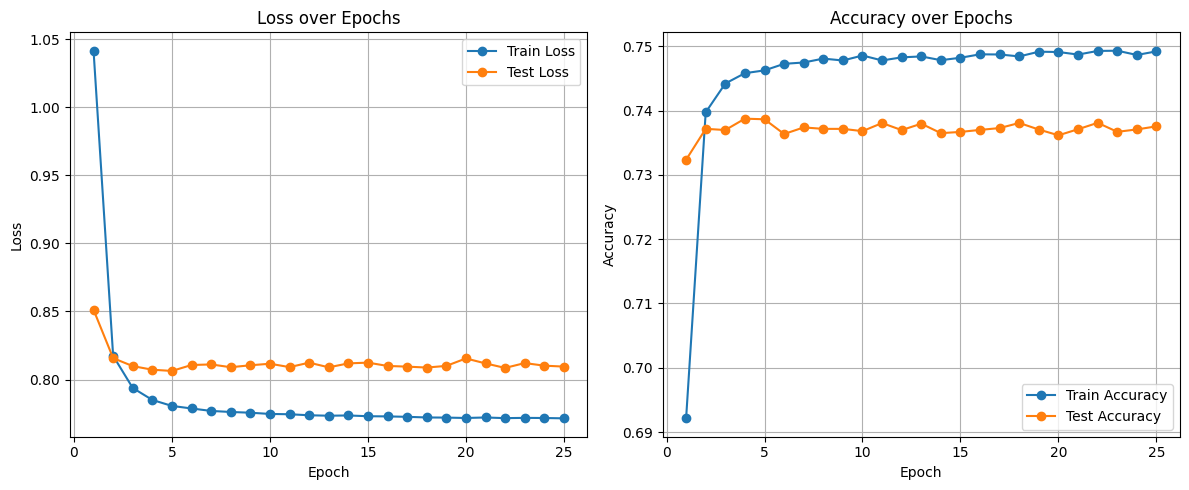

In [ ]:
# # Initialize
# model = Perceptron().to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# losses = train(model, combined_train_dl, loss_fn, optimizer, epochs=25)
# plot_training_loss(losses)
# evaluate(model, test_dl)

# Initialize
model = Perceptron().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train and track metrics
train_losses, train_accs, test_losses, test_accs = train_model(
    model, combined_train_dl, test_dl, loss_fn, optimizer, epochs=25
)

# Plot
plot_metrics(train_losses, test_losses, train_accs, test_accs)

Train using curriculum

Epoch 1/10, Train Loss: 0.9626, Train Acc: 0.7723, Test Loss: 1.2523, Test Acc: 0.6290
Epoch 2/10, Train Loss: 0.5067, Train Acc: 0.8718, Test Loss: 1.2389, Test Acc: 0.6266
Epoch 3/10, Train Loss: 0.4410, Train Acc: 0.8844, Test Loss: 1.2618, Test Acc: 0.6244
Epoch 4/10, Train Loss: 0.4092, Train Acc: 0.8913, Test Loss: 1.2871, Test Acc: 0.6235
Epoch 5/10, Train Loss: 0.3886, Train Acc: 0.8956, Test Loss: 1.3392, Test Acc: 0.6117
Epoch 6/10, Train Loss: 0.3744, Train Acc: 0.8986, Test Loss: 1.3307, Test Acc: 0.6201
Epoch 7/10, Train Loss: 0.3629, Train Acc: 0.9006, Test Loss: 1.3646, Test Acc: 0.6161
Epoch 8/10, Train Loss: 0.3554, Train Acc: 0.9029, Test Loss: 1.4129, Test Acc: 0.6078
Epoch 9/10, Train Loss: 0.3460, Train Acc: 0.9049, Test Loss: 1.4179, Test Acc: 0.6126
Epoch 10/10, Train Loss: 0.3413, Train Acc: 0.9060, Test Loss: 1.4667, Test Acc: 0.6037
Epoch 1/15, Train Loss: 0.4492, Train Acc: 0.8722, Test Loss: 1.0531, Test Acc: 0.6696
Epoch 2/15, Train Loss: 0.4265, Train Acc:

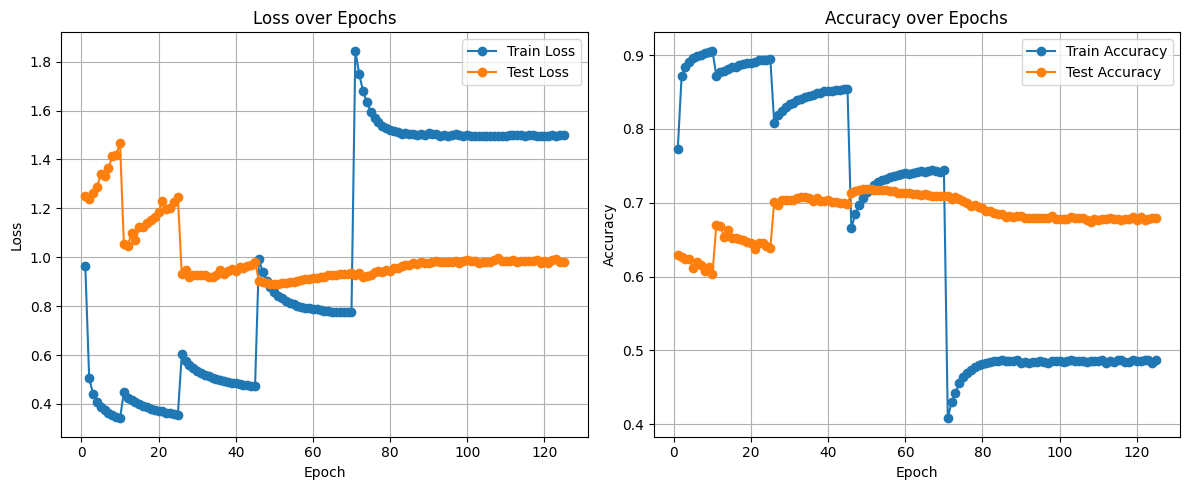

In [ ]:
# model2 = Perceptron().to(device)
# loss_fn = nn.CrossEntropyLoss().to(device)
# losses = np.array([])

# learning_rates = [0.06, 0.04, 0.03, 0.02, 0.01]
# epochs_per_level = [10,15,20,25,55]

# for i, noise_level in enumerate(noise_levels[:-1]):
#   train_dl = DataLoader(train_parts[i], batch_size=256, shuffle=True)
#   optimizer = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
#   losses = np.concatenate((losses, np.array(train(model2, train_dl, loss_fn, optimizer, epochs=epochs_per_level[i]))))

# plot_training_loss(losses)
# evaluate(model2, test_dl)

model2 = Perceptron().to(device)
loss_fn = nn.CrossEntropyLoss()

all_train_losses = []
all_test_losses = []
all_train_accuracies = []
all_test_accuracies = []

learning_rates = [0.06, 0.04, 0.03, 0.02, 0.01]
epochs_per_level = [10, 15, 20, 25, 55]

for i, noise_level in enumerate(noise_levels):
    train_dl = DataLoader(train_parts[i], batch_size=256, shuffle=True)
    optimizer = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

    train_losses, train_accs, test_losses, test_accs = train_model(
        model2, train_dl, test_dl, loss_fn, optimizer, epochs=epochs_per_level[i]
    )

    all_train_losses += train_losses
    all_test_losses += test_losses
    all_train_accuracies += train_accs
    all_test_accuracies += test_accs

plot_metrics(all_train_losses, all_test_losses, all_train_accuracies, all_test_accuracies)

## MLP (ReLU)

In [ ]:
class MLP_ReLU(nn.Module):
    def __init__(self, input_dim=784, output_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1000), nn.ReLU(),
            nn.Linear(1000, 500), nn.ReLU(),
            nn.Linear(500, 50), nn.ReLU(),
            nn.Linear(50, output_dim), nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
EPOCHS = 100

Epoch 1/100, Train Loss: 2.2968, Train Acc: 0.1738, Test Loss: 2.2870, Test Acc: 0.2574
Epoch 2/100, Train Loss: 2.2651, Train Acc: 0.2732, Test Loss: 2.2281, Test Acc: 0.2780
Epoch 3/100, Train Loss: 2.1117, Train Acc: 0.2976, Test Loss: 1.9465, Test Acc: 0.3339
Epoch 4/100, Train Loss: 1.8006, Train Acc: 0.3806, Test Loss: 1.6859, Test Acc: 0.4301
Epoch 5/100, Train Loss: 1.6048, Train Acc: 0.4563, Test Loss: 1.5390, Test Acc: 0.4768
Epoch 6/100, Train Loss: 1.4916, Train Acc: 0.4881, Test Loss: 1.4635, Test Acc: 0.4954
Epoch 7/100, Train Loss: 1.4337, Train Acc: 0.5025, Test Loss: 1.4223, Test Acc: 0.5050
Epoch 8/100, Train Loss: 1.4018, Train Acc: 0.5114, Test Loss: 1.3997, Test Acc: 0.5109
Epoch 9/100, Train Loss: 1.3799, Train Acc: 0.5176, Test Loss: 1.3830, Test Acc: 0.5146
Epoch 10/100, Train Loss: 1.3620, Train Acc: 0.5218, Test Loss: 1.3708, Test Acc: 0.5188
Epoch 11/100, Train Loss: 1.3482, Train Acc: 0.5254, Test Loss: 1.3585, Test Acc: 0.5213
Epoch 12/100, Train Loss: 1.33

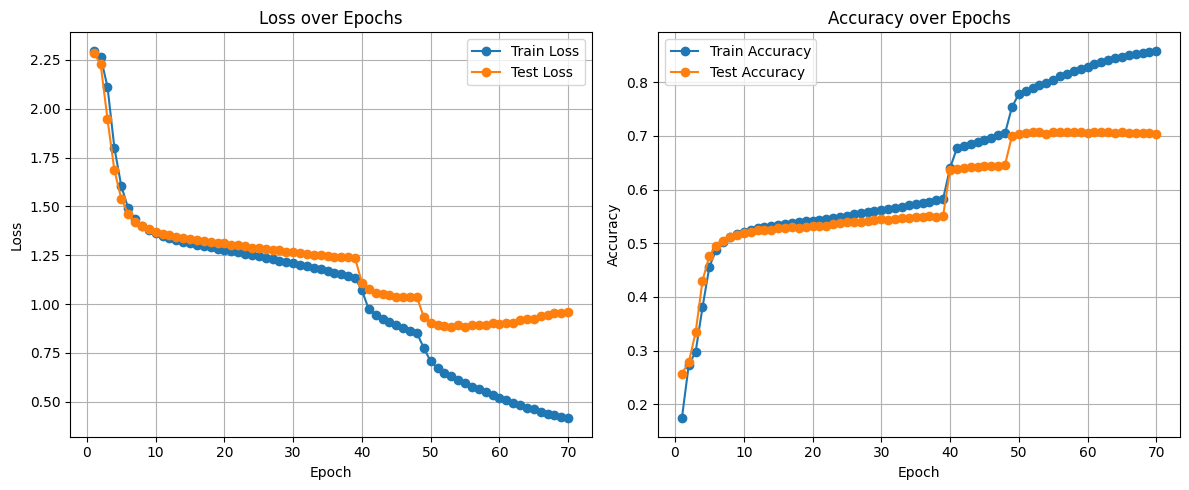

In [ ]:
mlp_relu_model = MLP_ReLU().to(device)
optimizer = torch.optim.SGD(mlp_relu_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# Use the new train function that also evaluates on test set
mlp_relu_train_losses, mlp_relu_train_accs, mlp_relu_test_losses, mlp_relu_test_accs = train_model(
    mlp_relu_model, combined_train_dl, test_dl, loss_fn, optimizer, epochs=EPOCHS, save_path = "mlp_relu_no_curriculum")

# Plot the losses and accuracies
plot_metrics(mlp_relu_train_losses, mlp_relu_test_losses, mlp_relu_train_accs, mlp_relu_test_accs)

In [ ]:
mlp_relu_model_curriculum = MLP_ReLU().to(device)

# Accumulate metrics across curriculum levels
mlp_relu_all_train_losses = []
mlp_relu_all_test_losses = []
mlp_relu_all_train_accuracies = []
mlp_relu_all_test_accuracies = []

for i, noise_level in enumerate(noise_levels):
    train_dl = DataLoader(binary_flip_datasets[noise_level], batch_size=256, shuffle=True)
    optimizer = torch.optim.SGD(mlp_relu_model_curriculum.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # Use new train function
    train_losses, train_accs, test_losses, test_accs = train_model(
        mlp_relu_model_curriculum, train_dl, test_dl, loss_fn, optimizer, epochs=EPOCHS, save_path = f"mlp_relu_forward_curriculum_{i+1}"
    )

    # Accumulate metrics
    mlp_relu_all_train_losses += train_losses
    mlp_relu_all_test_losses += test_losses
    mlp_relu_all_train_accuracies += train_accs
    mlp_relu_all_test_accuracies += test_accs

Epoch 1/100, Train Loss: 2.2986, Train Acc: 0.2099, Test Loss: 2.2976, Test Acc: 0.1987
Epoch 2/100, Train Loss: 2.2816, Train Acc: 0.3606, Test Loss: 2.2858, Test Acc: 0.2859
Epoch 3/100, Train Loss: 2.2508, Train Acc: 0.4638, Test Loss: 2.2612, Test Acc: 0.3185
Epoch 4/100, Train Loss: 2.1802, Train Acc: 0.4664, Test Loss: 2.1998, Test Acc: 0.2794
Epoch 5/100, Train Loss: 1.9951, Train Acc: 0.4633, Test Loss: 2.0484, Test Acc: 0.3531
Epoch 6/100, Train Loss: 1.6883, Train Acc: 0.5120, Test Loss: 1.8624, Test Acc: 0.4024
Epoch 7/100, Train Loss: 1.4641, Train Acc: 0.5349, Test Loss: 1.7502, Test Acc: 0.4159
Epoch 8/100, Train Loss: 1.3505, Train Acc: 0.5445, Test Loss: 1.6775, Test Acc: 0.4324
Epoch 9/100, Train Loss: 1.2903, Train Acc: 0.5491, Test Loss: 1.6543, Test Acc: 0.4307
Epoch 10/100, Train Loss: 1.2540, Train Acc: 0.5523, Test Loss: 1.6399, Test Acc: 0.4299
Epoch 11/100, Train Loss: 1.2282, Train Acc: 0.5537, Test Loss: 1.6214, Test Acc: 0.4341
Epoch 12/100, Train Loss: 1.20

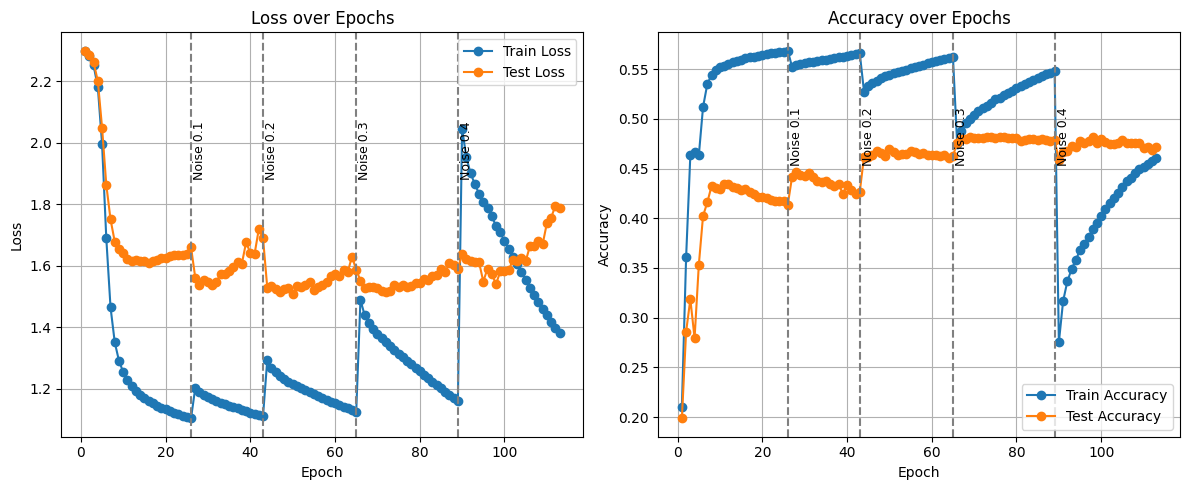

In [ ]:
# Plot the results
plot_metrics(mlp_relu_all_train_losses, mlp_relu_all_test_losses, mlp_relu_all_train_accuracies, mlp_relu_all_test_accuracies, epochs_per_level=[26,17,22,24,24], stage_labels=[f"Noise {nl}" for nl in noise_levels])

## MLP (Sigmoid)

Defining MLP

In [ ]:
class MLP_Sigmoid(nn.Module):
    def __init__(self, input_dim=784, output_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1000), nn.ReLU(),
            nn.Linear(1000, 500), nn.ReLU(),
            nn.Linear(500, 50), nn.ReLU(),
            nn.Linear(50, output_dim), nn.Sigmoid(), #nn.ReLU() nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

Training a MLP (no curriculum)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.03
EPOCHS = 100

Epoch 1/100, Train Loss: 2.0439, Train Acc: 0.3912, Test Loss: 1.8133, Test Acc: 0.5906
Epoch 2/100, Train Loss: 1.7506, Train Acc: 0.6375, Test Loss: 1.7260, Test Acc: 0.6568
Epoch 3/100, Train Loss: 1.7070, Train Acc: 0.6907, Test Loss: 1.7101, Test Acc: 0.6942
Epoch 4/100, Train Loss: 1.6907, Train Acc: 0.7075, Test Loss: 1.7003, Test Acc: 0.7010
Epoch 5/100, Train Loss: 1.6773, Train Acc: 0.7218, Test Loss: 1.6850, Test Acc: 0.7186
Epoch 6/100, Train Loss: 1.6660, Train Acc: 0.7376, Test Loss: 1.6772, Test Acc: 0.7358
Epoch 7/100, Train Loss: 1.6546, Train Acc: 0.7528, Test Loss: 1.6702, Test Acc: 0.7456
Epoch 8/100, Train Loss: 1.6422, Train Acc: 0.7684, Test Loss: 1.6617, Test Acc: 0.7567
Epoch 9/100, Train Loss: 1.6304, Train Acc: 0.7819, Test Loss: 1.6546, Test Acc: 0.7647
Epoch 10/100, Train Loss: 1.6183, Train Acc: 0.7958, Test Loss: 1.6513, Test Acc: 0.7703
Epoch 11/100, Train Loss: 1.6065, Train Acc: 0.8093, Test Loss: 1.6454, Test Acc: 0.7769
Epoch 12/100, Train Loss: 1.59

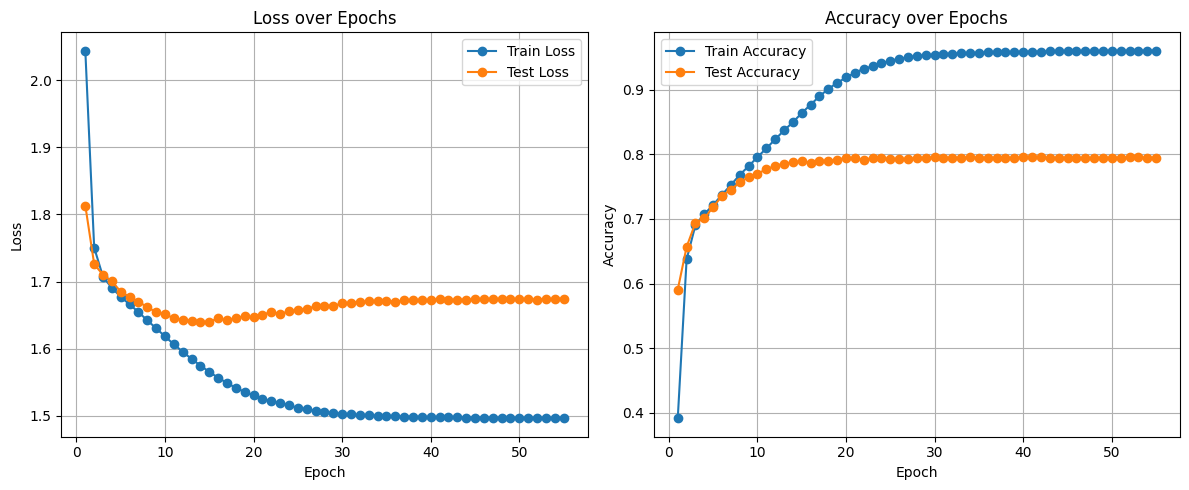

In [ ]:
mlp_sigmoid_model = MLP_Sigmoid().to(device)
optimizer = torch.optim.SGD(mlp_sigmoid_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# Use the new train function that also evaluates on test set
mlp_sigmoid_train_losses, mlp_sigmoid_train_accs, mlp_sigmoid_test_losses, mlp_sigmoid_test_accs = train_model(
    mlp_sigmoid_model, combined_train_dl, test_dl, loss_fn, optimizer, epochs=EPOCHS, save_path = "mlp_no_curriculum")

# Plot the losses and accuracies
plot_metrics(mlp_sigmoid_train_losses, mlp_sigmoid_test_losses, mlp_sigmoid_train_accs, mlp_sigmoid_test_accs)

Training MLP (forward curriculum)

In [ ]:
mlp_sigmoid_model_curriculum = MLP_Sigmoid().to(device)

# Accumulate metrics across curriculum levels
mlp_sigmoid_all_train_losses = []
mlp_sigmoid_all_test_losses = []
mlp_sigmoid_all_train_accuracies = []
mlp_sigmoid_all_test_accuracies = []

for i, noise_level in enumerate(noise_levels):
    train_dl = DataLoader(binary_flip_datasets[noise_level], batch_size=256, shuffle=True)
    optimizer = torch.optim.SGD(mlp_sigmoid_model_curriculum.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # Use new train function
    train_losses, train_accs, test_losses, test_accs = train_model(
        mlp_sigmoid_model_curriculum, train_dl, test_dl, loss_fn, optimizer, epochs=EPOCHS, save_path = f"mlp_forward_curriculum_{i+1}"
    )

    # Accumulate metrics
    mlp_sigmoid_all_train_losses += train_losses
    mlp_sigmoid_all_test_losses += test_losses
    mlp_sigmoid_all_train_accuracies += train_accs
    mlp_sigmoid_all_test_accuracies += test_accs


Epoch 1/100, Train Loss: 2.1535, Train Acc: 0.4362, Test Loss: 2.0055, Test Acc: 0.3633
Epoch 2/100, Train Loss: 1.6788, Train Acc: 0.6682, Test Loss: 1.9421, Test Acc: 0.4107
Epoch 3/100, Train Loss: 1.6081, Train Acc: 0.7651, Test Loss: 1.9086, Test Acc: 0.4790
Epoch 4/100, Train Loss: 1.5776, Train Acc: 0.8119, Test Loss: 1.9020, Test Acc: 0.4981
Epoch 5/100, Train Loss: 1.5613, Train Acc: 0.8461, Test Loss: 1.9086, Test Acc: 0.5136
Epoch 6/100, Train Loss: 1.5464, Train Acc: 0.9034, Test Loss: 1.9096, Test Acc: 0.5385
Epoch 7/100, Train Loss: 1.5327, Train Acc: 0.9244, Test Loss: 1.9032, Test Acc: 0.5463
Epoch 8/100, Train Loss: 1.5236, Train Acc: 0.9339, Test Loss: 1.9058, Test Acc: 0.5430
Epoch 9/100, Train Loss: 1.5166, Train Acc: 0.9408, Test Loss: 1.9030, Test Acc: 0.5443
Epoch 10/100, Train Loss: 1.5111, Train Acc: 0.9464, Test Loss: 1.8911, Test Acc: 0.5584
Epoch 11/100, Train Loss: 1.5067, Train Acc: 0.9510, Test Loss: 1.9048, Test Acc: 0.5425
Epoch 12/100, Train Loss: 1.50

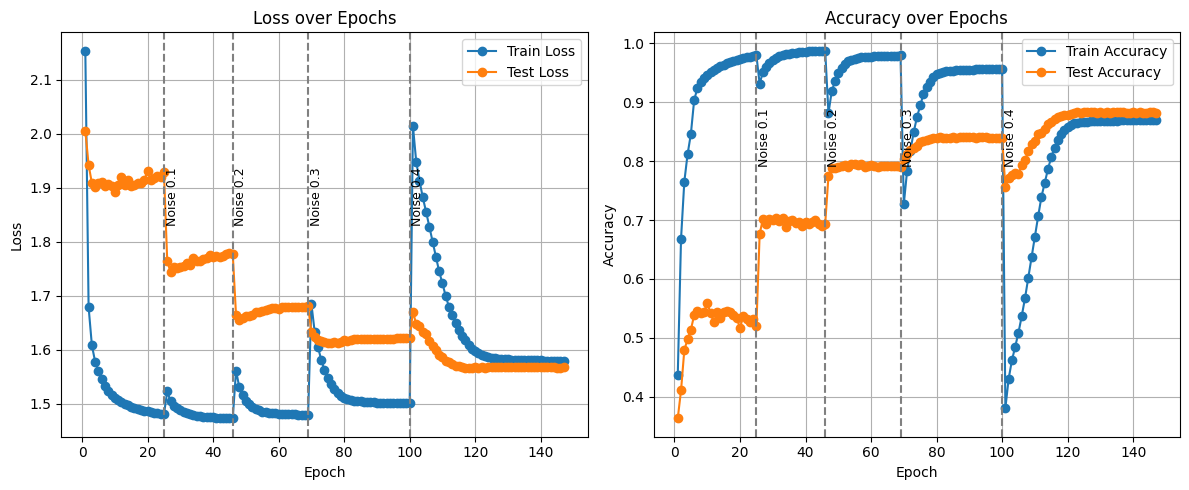

In [ ]:
# Plot the results
plot_metrics(mlp_sigmoid_all_train_losses, mlp_sigmoid_all_test_losses, mlp_sigmoid_all_train_accuracies, mlp_sigmoid_all_test_accuracies, epochs_per_level=[25, 21, 23, 31, 47], stage_labels=[f"Noise {nl}" for nl in noise_levels])

## MLP (Softmax)

Defining MLP

In [ ]:
class MLP_Softmax(nn.Module):
    def __init__(self, input_dim=784, output_dim=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1000), nn.ReLU(),
            nn.Linear(1000, 500), nn.ReLU(),
            nn.Linear(500, 50), nn.ReLU(),
            nn.Linear(50, output_dim), nn.LogSoftmax(dim=-1), #nn.ReLU() nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

Training a MLP (no curriculum)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
EPOCHS = 100

Epoch 1/100, Train Loss: 2.2975, Train Acc: 0.1155, Test Loss: 2.2867, Test Acc: 0.1367
Epoch 2/100, Train Loss: 2.2617, Train Acc: 0.2514, Test Loss: 2.2198, Test Acc: 0.3638
Epoch 3/100, Train Loss: 2.0397, Train Acc: 0.4155, Test Loss: 1.7051, Test Acc: 0.4907
Epoch 4/100, Train Loss: 1.3777, Train Acc: 0.5595, Test Loss: 1.1644, Test Acc: 0.6108
Epoch 5/100, Train Loss: 1.0536, Train Acc: 0.6519, Test Loss: 0.9689, Test Acc: 0.6824
Epoch 6/100, Train Loss: 0.9217, Train Acc: 0.6973, Test Loss: 0.8994, Test Acc: 0.7044
Epoch 7/100, Train Loss: 0.8663, Train Acc: 0.7163, Test Loss: 0.8600, Test Acc: 0.7186
Epoch 8/100, Train Loss: 0.8346, Train Acc: 0.7283, Test Loss: 0.8391, Test Acc: 0.7251
Epoch 9/100, Train Loss: 0.8142, Train Acc: 0.7349, Test Loss: 0.8309, Test Acc: 0.7287
Epoch 10/100, Train Loss: 0.7958, Train Acc: 0.7406, Test Loss: 0.8140, Test Acc: 0.7340
Epoch 11/100, Train Loss: 0.7816, Train Acc: 0.7460, Test Loss: 0.8019, Test Acc: 0.7374
Epoch 12/100, Train Loss: 0.76

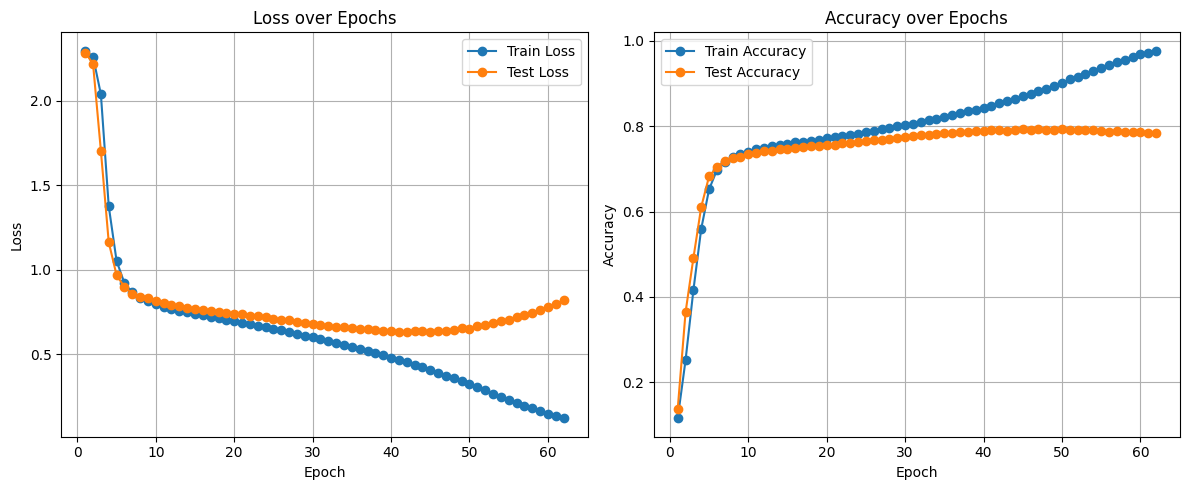

In [ ]:
mlp_softmax_model = MLP_Softmax().to(device)
optimizer = torch.optim.SGD(mlp_softmax_model.parameters(), lr=LEARNING_RATE, momentum=0.9)

# Use the new train function that also evaluates on test set
mlp_softmax_train_losses, mlp_softmax_train_accs, mlp_softmax_test_losses, mlp_softmax_test_accs = train_model(
    mlp_softmax_model, combined_train_dl, test_dl, loss_fn, optimizer, epochs=EPOCHS, save_path = "mlp_no_curriculum")

# Plot the losses and accuracies
plot_metrics(mlp_softmax_train_losses, mlp_softmax_test_losses, mlp_softmax_train_accs, mlp_softmax_test_accs)

Training MLP (forward curriculum)

In [ ]:
mlp_softmax_model_curriculum = MLP_Softmax().to(device)

# Accumulate metrics across curriculum levels
mlp_softmax_all_train_losses = []
mlp_softmax_all_test_losses = []
mlp_softmax_all_train_accuracies = []
mlp_softmax_all_test_accuracies = []

for i, noise_level in enumerate(noise_levels):
    train_dl = DataLoader(binary_flip_datasets[noise_level], batch_size=256, shuffle=True)
    optimizer = torch.optim.SGD(mlp_softmax_model_curriculum.parameters(), lr=LEARNING_RATE, momentum=0.9)

    # Use new train function
    train_losses, train_accs, test_losses, test_accs = train_model(
        mlp_softmax_model_curriculum, train_dl, test_dl, loss_fn, optimizer, epochs=EPOCHS, save_path = f"mlp_forward_curriculum_{i+1}"
    )

    # Accumulate metrics
    mlp_softmax_all_train_losses += train_losses
    mlp_softmax_all_test_losses += test_losses
    mlp_softmax_all_train_accuracies += train_accs
    mlp_softmax_all_test_accuracies += test_accs


Epoch 1/100, Train Loss: 2.2924, Train Acc: 0.1899, Test Loss: 2.2892, Test Acc: 0.2002
Epoch 2/100, Train Loss: 2.2505, Train Acc: 0.3436, Test Loss: 2.2550, Test Acc: 0.2462
Epoch 3/100, Train Loss: 2.1308, Train Acc: 0.4903, Test Loss: 2.1459, Test Acc: 0.2915
Epoch 4/100, Train Loss: 1.7352, Train Acc: 0.6063, Test Loss: 1.8236, Test Acc: 0.4193
Epoch 5/100, Train Loss: 1.1386, Train Acc: 0.6958, Test Loss: 1.7939, Test Acc: 0.4520
Epoch 6/100, Train Loss: 0.8002, Train Acc: 0.7678, Test Loss: 1.8096, Test Acc: 0.4974
Epoch 7/100, Train Loss: 0.6324, Train Acc: 0.8157, Test Loss: 1.7884, Test Acc: 0.5272
Epoch 8/100, Train Loss: 0.5386, Train Acc: 0.8439, Test Loss: 1.7689, Test Acc: 0.5473
Epoch 9/100, Train Loss: 0.4791, Train Acc: 0.8619, Test Loss: 1.8215, Test Acc: 0.5487
Epoch 10/100, Train Loss: 0.4396, Train Acc: 0.8740, Test Loss: 1.8877, Test Acc: 0.5523
Epoch 11/100, Train Loss: 0.4105, Train Acc: 0.8832, Test Loss: 1.8689, Test Acc: 0.5609
Epoch 12/100, Train Loss: 0.38

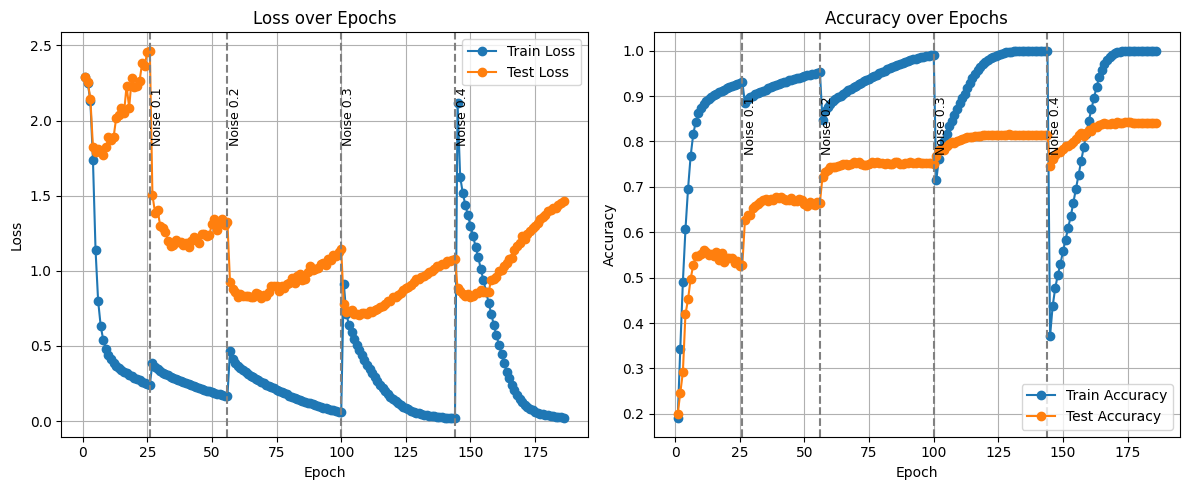

In [ ]:
# Plot the results
plot_metrics(mlp_softmax_all_train_losses, mlp_softmax_all_test_losses, mlp_softmax_all_train_accuracies, mlp_softmax_all_test_accuracies, epochs_per_level=[26, 30, 44, 44, 42], stage_labels=[f"Noise {nl}" for nl in noise_levels])